In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np
import os

# 1. Twitter tennis datasets

We compiled two separate tweet collections, `RG17` for **Roland-Garros 2017**, the French
Open Tennis Tournament, and `uo17` for **US Open 2017**, the United States Open Tennis
Championship.

## Data collection

- We gathered data with the Twitter Search API, by using the following two separate sets of keywords:

```
{@rolandgarros, #RolandGarros2017,
#rolandgarros2017, #RolandGarros, #rolandgarros,
#FrenchOpen, #frenchopen, #RG17, #rg17}

{#usopen, #Usopen, #UsOpen, #USOPEN,
#usopen17, #UsOpen17, #Usopen2017, @usopen,
#WTA, #wta, #ATP, #atp, @WTA, @ATPWorldTour,
#Tennis, #tennis, #tenis, #Tenis}
```

- Extract the underlying mention graph from the tweets (retweets are excluded)

## Event timeline

- **Qualifications:**
   - RG17: 2017-05-22 -> 2017-05-26 (we collected data only from 2017-05-24)
   - UO17: 2017-08-22 -> 2017-08-25
- **Days without tournaments:**
   - RG17: 2017-05-27
   - UO17: 2017-08-26 -> 2017-08-27
- **Main tournaments:** used for supervised model evaluation
   - RG17: 2017-05-28 -> 2017-06-11 (15 days)
   - UO17: 2017-08-28 -> 2017-09-10 (14 days)

## Dataset preparation

```
pip install online-node2vec

```

In [4]:
from online_node2vec.data.tennis_handler import download_data_set
data_dir = "../data"
dataset_id = "rg17"

In [5]:
preproc_dir, handler = download_data_set(data_dir, dataset_id)
print("Path for preprocessed data:", preproc_dir)

{'data_id': 'rg17', 'include_qualifiers': True, 'dates': ['2017-05-24', '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28', '2017-05-29', '2017-05-30', '2017-05-31', '2017-06-01', '2017-06-02', '2017-06-03', '2017-06-04', '2017-06-05', '2017-06-06', '2017-06-07', '2017-06-08', '2017-06-09', '2017-06-10', '2017-06-11'], 'dates_with_no_game': ['2017-05-27'], 'start_time': 1495576800, 'end_time': 1497218400, 'number_of_edges': 336234, 'number_of_nodes': 78095}
Exporting files STARTED
2017-05-24 66
2017-05-25 43
2017-05-26 34
2017-05-27 0
2017-05-28 60
2017-05-29 118
2017-05-30 138
2017-05-31 194
2017-06-01 148
2017-06-02 120
2017-06-03 83
2017-06-04 116
2017-06-05 81
2017-06-06 71
2017-06-07 96
2017-06-08 64
2017-06-09 57
2017-06-10 33
2017-06-11 18
Exporting files DONE
Path for preprocessed data: ../data/rg17_preprocessed


### Edge stream

- **Nodes:** Twitter accounts
- **Edges:** 
   - @-mentions between accounts
   - timestamp is extracted from the tweet

In [6]:
edges = np.loadtxt(os.path.join(preproc_dir, "edges.csv"), delimiter="|", max_rows=5)
print(edges)

[[1.49557681e+09 3.42138386e+09 3.42138386e+09]
 [1.49557683e+09 1.09918332e+08 3.49926440e+07]
 [1.49557683e+09 1.09918332e+08 5.03355910e+07]
 [1.49557684e+09 4.13885197e+08 4.22203530e+07]
 [1.49557684e+09 4.13885197e+08 7.19754460e+07]]


Number of nodes and edges in the RG17 mention graph. 
- During the qualifiers the number of interactions is low. 
- Then user activity increases as the championship starts from May 28  
- Activity burst due to Men’s Singles finals on June 7–9–11

Text(0.5, 1.0, 'RG17')

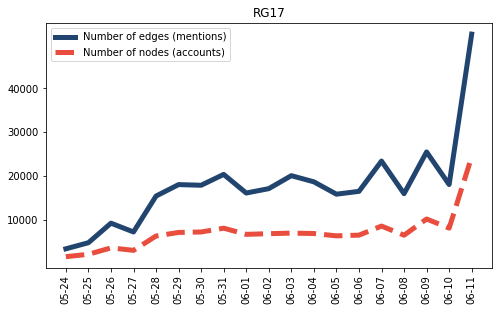

In [7]:
fig = handler.visualize(kind="graph", figsize=(8,5))
fig.axes[0].set_title("RG17")

### Official event schedule

In [8]:
handler.schedule.head()

,day,date,courtName,orderNumber,matchHeader,startDate,playerName active,playerName opponent,matchScore
0,Qualifying Day 1,2017-05-22,Court 6,1,Qualifying Men's Singles - Round 1,10:00 AM,Laslo Djere,Benjamin Becker,6-2 2-6 6-3
1,Qualifying Day 1,2017-05-22,Court 6,2,Qualifying Men's Singles - Round 1,10:00 AM,Reilly Opelka,Daniel Munoz De La Nava,4-6 7-6(4) 6-4
2,Qualifying Day 1,2017-05-22,Court 6,3,Qualifying Men's Singles - Round 1,10:00 AM,Marius Copil,Denis Shapovalov,6-0 4-6 6-2
3,Qualifying Day 1,2017-05-22,Court 6,4,Qualifying Men's Singles - Round 1,10:00 AM,Paul-Henri Mathieu,Tatsuma Ito,6-7(0) 6-2 6-2
4,Qualifying Day 1,2017-05-22,Court 6,5,Qualifying Men's Singles - Round 1,10:00 AM,Casper Ruud,Yannik Reuter,6-3 6-2


### Tennis player accounts on Twitter

- The total number of professional participants for Roland-Garros is 698. Unfortunately, many of the players have no Twitter accounts.

- We assigned players to accounts by the Twitter Search API’s people endpoint; however, the API was sometimes unable to identify the accounts of the active players.

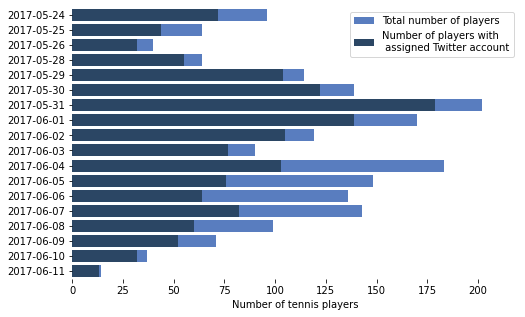

Text(0.5, 1.0, 'RG17')

In [9]:
fig = handler.visualize(kind="players", figsize=(8,5))
fig.axes[0].set_title("RG17")

### Node relevance labels

- An account in the Twitter mention graph is **relevant** if it corresponds to a tennis player that participated in the tournaments of the given day
- Binary node relevance labels change from day to day based on the official schedule of the tournaments.
- Supervised evaluation for the main tournaments: 2017-05-28 -> 2017-06-11 (15 days)

In [10]:
players_in_finals = np.loadtxt(os.path.join(preproc_dir, "labels_18.csv"), delimiter=" ")
print("Found relevant players on the last day:", len(players_in_finals))

Found relevant players on the last day: 18


In [11]:
print(players_in_finals[:5])

[[1.78612820e+07 1.00000000e+00]
 [6.51870670e+07 1.00000000e+00]
 [7.41460950e+07 1.00000000e+00]
 [1.10398012e+08 1.00000000e+00]
 [1.90989915e+08 1.00000000e+00]]


# 2. Online node embeddings

## i.) Initialize models

Our online node embedding algorithms have two components:

- **updater:** sample node pairs for representation learning
- **learner:** online Word2Vec implementation

In [12]:
from online_node2vec.online.walk_sampling import StreamWalkUpdater
from online_node2vec.online.walk_sampling import SecondOrderUpdater
from online_node2vec.online.w2v_learners import OnlineWord2Vec

### a.) StreamWalk

**Updater parameters:**

- half_life : Half-life in seconds for time decay
- max_len : Maximum length of the sampled temporal random walks
- beta : Damping factor for long paths
- k: Number of sampled walks for each edge update

In [13]:
sw_updater = StreamWalkUpdater(
    half_life=3*3600, 
    max_len=2, 
    beta=0.9, 
    k=4,
)    

<img src="http://info.ilab.sztaki.hu/~fberes/tennis/streamWalk_v2.png" alt="drawing" width="370"/>

**Learner parameters:**

- embedding_dims :Dimensions of the representation
- lr_rate : Learning rate
- neg_rate: Negative rate
- mirror: Feed sampled node pairs in both order to the learner
- exportW1: Select representation matrix

In [14]:
dimensions = 128

In [15]:
sw_learner = OnlineWord2Vec(
    embedding_dims=dimensions, 
    lr_rate=0.035, 
    neg_rate=10, 
    mirror=False, 
    exportW1=False, 
)

### b.) Online second order similarity

**Updater parameters:**

- half_life : Half-life in seconds for time decay
- num_hash : Number of hash functions to use for similarity approximation
- hash_gen : Hash function generator class.

In [16]:
from online_node2vec.online.hash_utils import ModHashGenerator
so_updater = SecondOrderUpdater(
    half_life=12*3600,
    num_hash=20,
    hash_generator=ModHashGenerator()
)

**Learner parameters:**

- uniform_ratio: Fraction of uniform random negative samples. Remaining negative samples are chosen from past positive training instances.

In [17]:
so_learner = OnlineWord2Vec(
    embedding_dims=dimensions, 
    lr_rate=0.01, 
    neg_rate=20, 
    uniform_ratio=0.8,
)

## ii.) Run models

**Experiment setup:**
- node representations are
    - calculated for the first 3 days
    - exported in every 6 hours
- the total elapsed time and Word2Vec training time are shown in seconds

In [18]:
result_folder = "../results/"
total_days = 3
delta_time = 6*3600
root_dir = "%s/%s/features_%s/delta_%i" % (result_folder, dataset_id, 0, delta_time)

from online_node2vec.data.tennis_handler import load_edge_data
edge_data, start_time, end_time = load_edge_data(data_dir, dataset_id, total_days)

#### Calculate and export StreamWalk representations

- OnlineNode2Vec: learnig after each edge arrival
- LazyNode2Vec: store sampled node pairs -> delayed learning before emb. export

In [19]:
# Execution takes more time!
from online_node2vec.online.online_node2vec_models import LazyNode2Vec # or OnlineNode2Vec
streamwalk = LazyNode2Vec(sw_updater, sw_learner, is_decayed=True)
streamwalk_output_dir = streamwalk.run(edge_data, delta_time, root_dir, start_time=start_time, end_time=end_time)

Model was INITIALIZED: lazy_decayedTrue-streamwalk_hl10800_ml2_beta0.90_cutoff604800_k4_fullwFalse-onlinew2v_dim128_lr0.0350_neg10_uratio1.00_square_mirrorFalse_omFalse_inituniform_expW1False_i86400_tnFalse_win2_pairsTrue
Original number of edges: 336234
Number of edges after temporal filter: 51398
Number of edges after dropping loop edges: 51134
Number of nodes in the remaining data: 16412
Experiment was STARTED
0 1 1.0735902786254883
1 4 3.720273733139038
2 13 11.281243801116943
3 20 16.458441257476807
Updating noise with 122920 records
4 23 17.756787061691284
5 27 20.282190084457397
6 38 28.75174045562744
7 48 35.46511745452881
8 52 36.93261218070984
Updating noise with 277416 records
9 57 39.29975080490112
10 68 46.70045566558838
11 80 54.43535494804382
Experiment was FINISHED


#### Calculate and export online second order similarity representations 

In [20]:
# Execution takes more time!
second_order = LazyNode2Vec(so_updater, so_learner, is_decayed=True)
second_order_output_dir = second_order.run(edge_data, delta_time, root_dir, start_time=start_time, end_time=end_time)

Model was INITIALIZED: lazy_decayedTrue-secondorder_hl43200_numh20_modhash200000_in0.00_out1.00_incrTrue-onlinew2v_dim128_lr0.0100_neg20_uratio0.80_square_mirrorTrue_omFalse_inituniform_expW1True_i86400_tnFalse_win2_pairsTrue
Original number of edges: 336234
Number of edges after temporal filter: 51398
Number of edges after dropping loop edges: 51134
Number of nodes in the remaining data: 16412
Experiment was STARTED
0 6 5.489934682846069
1 21 19.647898197174072
2 46 41.74763011932373
3 63 56.68664050102234
Updating noise with 180692 records
4 70 61.37628936767578
5 81 70.1724681854248
6 108 92.47021079063416
7 129 109.57655811309814
8 137 114.76064467430115
Updating noise with 362580 records
9 146 121.1062400341034
10 170 139.56473541259766
11 194 157.93646359443665
Experiment was FINISHED


## iii.) Observe node representations over time

### Load label information

In [21]:
from online_node2vec.data.tennis_handler import get_data_info
gen_id_to_account, player_labels = get_data_info(os.path.join(data_dir, "%s_preprocessed" % dataset_id))

### Load node representations

In [22]:
print(streamwalk_output_dir)

../results//rg17/features_0/delta_21600/lazy_decayedTrue-streamwalk_hl10800_ml2_beta0.90_cutoff604800_k4_fullwFalse-onlinew2v_dim128_lr0.0350_neg10_uratio1.00_square_mirrorFalse_omFalse_inituniform_expW1False_i86400_tnFalse_win2_pairsTrue


In [23]:
model_dirs = {
    "so":second_order_output_dir,
    "sw":streamwalk_output_dir
}

In [24]:
from online_node2vec.data.n2v_embedding_handler import load_n2v_features
feature_sets = {}
for model_id in ["sw","so"]:
    feature_sets[model_id] = load_n2v_features(
        model_dirs[model_id], 
        delta_time, 
        total_days, 
        player_labels, 
        verbose=False
    )

0 12 1
0 12 1


### Animation: Tennis player account embedding

Only visible in the Jupyter notebook

- **Nodes:** Twitter accounts of tennis players
    - **red:** players who play on the given day
    - **blue:** player who doesn't play on the given day
    - colors change from day to day (after every 4 snapshots)
    
- **Representations:**
    - initialized uniformly at random in a 128-dimensional space (close to the origo in snapshot=0)
    - updated online as @-mention arrive in the edge stream (we only show the first two coordinates)
    - performance is considered better when red nodes are mapped close to each other
- **Results:**
    - StreamWalk (with 3 hours half-time) efficiently capture daily players by the end of each day
    - Online second order similarity (with longer half-life) can also map daily players close to each other in the embedded space:
        - Try to find red node groups related to Women's or Men's Singles around snapshot 7

In [25]:
dates = ["2017-05-28","2017-05-29","2017-05-30"]

In [26]:
from notebook_utils import prepare_animation
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

fig_sw, embedding_sw = prepare_animation(
    handler, 
    player_labels, 
    feature_sets["sw"], 
    delta_time, 
    "StreamWalk", 
    dates
)
fig_so, embedding_so = prepare_animation(
    handler, 
    player_labels, 
    feature_sets["so"], 
    delta_time, 
    "Online second order", 
    dates
)

In [27]:
fig_sw

In [28]:
fig_so

## iv.) Task: similarity search

**active account:** account `n` is active on the given day, if it belongs to a tennis player who participated in a completed, canceled, or resumed game.

We use [NDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain) (Al-Maskari et al. 2007) to evaluate how other active accounts are similar
to a selected one. NDCG is a measure for ranked lists that assigns higher score if active
accounts appear with higher rank in the similarity list. 


In our experiments, we compute
the average of the **NDCG@100** for the active accounts as query nodes to measure the
performance of a single model in any given snapshot. **Dot product** is used to measure the similarity of node representations.

### a.) Single model performance

In [30]:
from online_node2vec.evaluation.ndcg_computer import parallel_eval_ndcg
metric = "-dot"
max_threads = 2
model_performance = {}
for model_id in ["sw","so"]:
    model_performance[model_id] = pd.concat(parallel_eval_ndcg(
        feature_sets[model_id], 
        gen_id_to_account, 
        metric,
        n_threads=max_threads
    ))

In [31]:
sw_ndcg = model_performance["sw"]["ndcg"].mean()
so_ndcg = model_performance["so"]["ndcg"].mean()
print("StreamWalk NDCG:", sw_ndcg)
print("Online second order NDCG:", so_ndcg)

StreamWalk NDCG: 0.2825806670758573
Online second order NDCG: 0.2770961599957779


### b.) Combination of StreamWalk and online second order similarity

- StreamWalk and online second order similarity can learn different network properties from the edge stream. 
- We combined the output of StreamWalk and second order similarity by using the weighted average of the corresponding inner products as similarity. 

In [32]:
from online_node2vec.evaluation.ndcg_computer import parallel_combined_eval_ndcg
from tqdm import tqdm

weights = list(np.arange(0.1,1.1,0.1))

# Execution takes more time!
combination_performance = []
for second_order_weight in tqdm(weights):
    combination_performance.append(pd.concat(parallel_combined_eval_ndcg(
        feature_sets["so"], 
        feature_sets["sw"],
        second_order_weight, 
        gen_id_to_account, 
        metric, 
        n_threads=max_threads
    )))

100%|██████████| 10/10 [11:23<00:00, 68.32s/it]


In [33]:
mean_ndcg = [sw_ndcg] + [perf["ndcg"].mean() for perf in combination_performance] + [so_ndcg]
so_weights = [0.0] + weights + [1.0]

#### Combination on the first 3 days

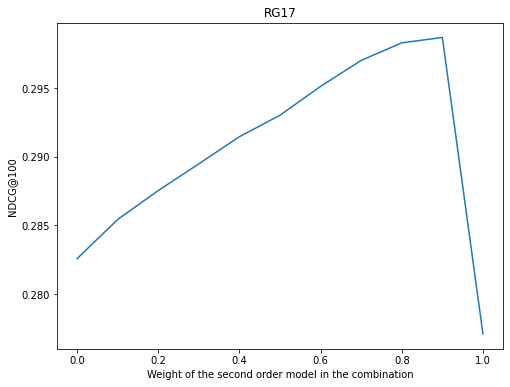

In [34]:
plt.figure(figsize=(8,6))
plt.plot(so_weights, mean_ndcg)
plt.title(dataset_id.upper())
plt.xlabel("Weight of the second order model in the combination")
plt.ylabel("NDCG@100")
plt.show()

### c.) Results for the complete RG17 and UO17 datasets

- Average performance is shown based on 10 independent experiments

![](http://info.ilab.sztaki.hu/~fberes/tennis/combination.png)

![](http://info.ilab.sztaki.hu/~fberes/tennis/performance_table.png)

<img src="http://info.ilab.sztaki.hu/~fberes/tennis/half_life.png" alt="drawing" width="585"/>

<img src="http://info.ilab.sztaki.hu/~fberes/tennis/number_of_walks_and_hash_functions.png" alt="drawing" width="570"/>

#### Temporal performance

- **Cold start:** SW and SO performs significantly better after a few days
- **Performance drop** on day 10 (2017-06-06): 
   - Quarterfinals start on this day -> much less players per day than before
   - SW could better adapt to this concept drift SO (due to stronger time decay)

![](http://info.ilab.sztaki.hu/~fberes/tennis/temporal_performance.png)